### Import Libraries

In [1]:
# Import fungsi time untuk mendapatkan nilai waktu mulai eksekusi
import time
a = time.time()
# Import fungsi matematika
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Import fungsi Operating System Directory
import os
from __future__ import print_function, division
from builtins import range, input
# Install and/or Import TF dan Keras & show version
# !pip install tensorflow
# !pip install keras
import tensorflow as tf
from tensorflow import keras
print('Tensorflow version : ', tf.__version__)
print('Keras version : ', keras.__version__)
# Import Pre-trained Model VGG16
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
# Import fungsi untuk Confusion Matrix dan Plot Grafik
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from glob import glob

Tensorflow version :  2.9.1
Keras version :  2.9.0


### Explore Data

In [2]:
# Explore Dataset
from random import shuffle

# Set to Current Working Directory
cwd = os.getcwd()
PATH = os.path.join(cwd, 'OCTOne-tenth')

# Set to train dir and show number of files
train_path = os.path.join(PATH, 'train')
train_files = glob(train_path + '/*/*.jp*g')
print('Number of training files:', len(train_files))

#Split training set to 50%, 25%, or 10% for faster experimental training


# Set to test dir and show number of files
valid_path = os.path.join(PATH, 'test')
valid_image_files = glob(valid_path + '/*/*.jp*g')
print("Number of Images for validating: ",len(valid_image_files))



Number of training files: 10829
Number of Images for validating:  1000


Found 10829 files belonging to 4 classes.
Found 1000 files belonging to 4 classes.
Found 10829 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Number of classes:  4


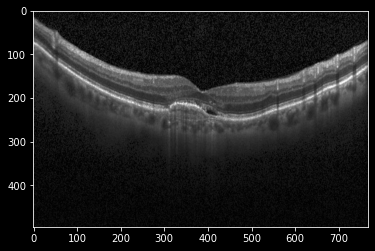

In [3]:
batch_size = 32
# re-size all the images to 100x100
IMAGE_SIZE = [100, 100]

# create generators

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    shuffle=True,
    batch_size=batch_size,
    image_size=IMAGE_SIZE
)

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    valid_path,
    shuffle=True,
    batch_size=batch_size,
    image_size=IMAGE_SIZE
)

# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

# useful for getting number of classes
folders = glob(train_path + '/*')
print("Number of classes: ",len(folders))

# look at an image for fun
plt.imshow(keras.utils.load_img(np.random.choice(train_files)))

plt.show()

In [4]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

# our layers
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)


# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

### Loss and Optimization functions

In [5]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

Found 1000 images belonging to 4 classes.
{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
min: -123.68 max: 151.061


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


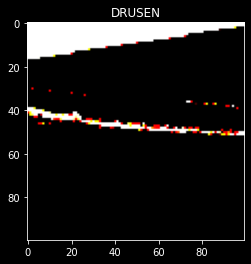

In [6]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [7]:
# training config:
epochs = 30

# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(train_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

C:\Users\LABILK~1\AppData\Local\Temp/ipykernel_5332/2414522659.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/30
338/338 [==============================] - 227s 671ms/step - loss: 4.1710 - accuracy: 0.6568 - val_loss: 6.8103 - val_accuracy: 0.5544
Epoch 2/30
338/338 [==============================] - 229s 677ms/step - loss: 3.2692 - accuracy: 0.7159 - val_loss: 7.1848 - val_accuracy: 0.5796
Epoch 3/30
338/338 [==============================] - 221s 654ms/step - loss: 3.1877 - accuracy: 0.7365 - val_loss: 5.9608 - val_accuracy: 0.6008
Epoch 4/30
338/338 [==============================] - 223s 659ms/step - loss: 3.0839 - accuracy: 0.7432 - val_loss: 6.5297 - val_accuracy: 0.6069
Epoch 5/30
338/338 [==============================] - 222s 657ms/step - loss: 3.2171 - accuracy: 0.7432 - val_loss: 7.7202 - val_accuracy: 0.5907
Epoch 6/30
338/338 [==============================] - 224s 663ms/step - loss: 3.0016 - accuracy: 0.7493 - val_loss: 5.6373 - val_accuracy: 0.6442
Epoch 7/30
338/338 [==============================] - 222s 656ms/step - loss: 3.0635 - accuracy: 0.7553 - val_loss: 4.8841 -

In [8]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
    cm = confusion_matrix(targets, predictions)
    return cm


cm = get_confusion_matrix(train_path, len(train_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)




Generating confusion matrix 10829
Found 10829 images belonging to 4 classes.
2/2 [==============================] - 1s 585ms/step
50
2/2 [==============================] - 1s 590ms/step
100
2/2 [==============================] - 1s 589ms/step
150
1/1 [==============================] - 0s 350ms/step
[[3072   85  114  449]
 [  83  484   14  553]
 [  91   22  221  527]
 [  80   90   39 4905]]
Generating confusion matrix 1000
Found 1000 images belonging to 4 classes.
2/2 [==============================] - 1s 168ms/step
[[229   8   2  11]
 [ 56 126   0  68]
 [ 49  15  39 147]
 [  6   5   2 237]]


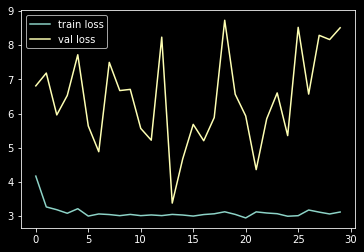

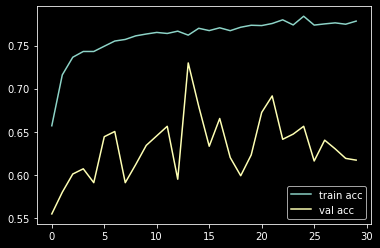

In [9]:
# plot Loss and Accuracies

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


Confusion matrix, without normalization
[[3072   85  114  449]
 [  83  484   14  553]
 [  91   22  221  527]
 [  80   90   39 4905]]


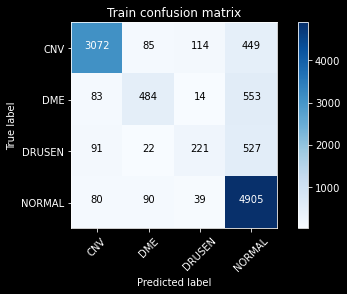

Confusion matrix, without normalization
[[229   8   2  11]
 [ 56 126   0  68]
 [ 49  15  39 147]
 [  6   5   2 237]]


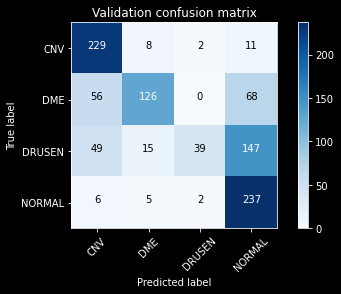

In [10]:
# Plot Confusion Matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [11]:
b = time.time()
print("time: ", b - a)

time:  6932.827804327011
